## Churn Modelling, notatnik I
Projekt zaliczeniowy Praktyczny Machine Learning w Pythonie <br>
Autor: Maciej Odziemczyk (388581)<br>
Wydział Nauk Ekonomicznych UW<br>
czerwiec 2020


##### Spis treści:
 - wstępna obróbka danych,
     - usunięcie zmiennych identyfikujących obserwacje (RowNumber, CustomerID, Surname - dyskusyjne),
     - zbadanie bilansowania zbioru i korelacji zmiennych ciągłych - dobór stosownych wariantów walidacyjnych:
         - warstwowa walidacja krzyżowa, AUC-PR jako główna metryka, ROC-AUC jako poboczna,
 - pierwszy model - logit,
 - sprawdzenie możliwości zbioru danych - Random Forest i XGboost,
     - RF i XGB wymagały specjalnego przygotowania danych - label encoding,
     - praca z RF i XGB:
         - "suche przebiegi",
         - weryfikacja wrażliwości na hiperparametry, sekwencyjny dobór i zawężenie zakresów optymalnych,
         - random search,
         - feature importance, feature selection, wstępne feature engenieering (logarytmy, prosta decylyzacja).

In [1]:
import time
kernelstart = time.time()

In [2]:
# import bibliotek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# zmiana ustawień wyświetlania dataframe
pd.set_option("display.max_columns", 30)
pd.set_option("display.max_rows", 50)

In [4]:
df = pd.read_csv("Churn_Modelling.csv")

In [5]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


 - tenure: Ile czasu klient subskrybuje usługę - dyskretna od 1 do 10
 - CreditScore: ciągła
 - Age: ciągła
 - Balance: ciągła
 - EstimatedSalary: ciągła

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [7]:
# usuwanie atrybutów bezpośrednio identyfikujących obserwacje
df.drop(labels = ['RowNumber', 'CustomerId', 'Surname'], axis = 1, inplace = True)

In [8]:
# sprawdzenie czy rzeczywiście nie ma braków danych
print('Nie ma nulli: {}'.format(df.dropna().shape == df.shape))

Nie ma nulli: True


In [9]:
# zmienne numeryczne
num = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

##### Zbadanie zbilanoswania danych

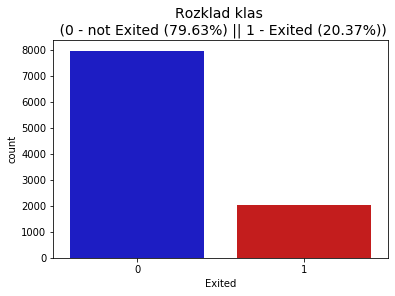

In [10]:
# rozkład etykiet - balans 
colors = ["#0101DF", "#DF0101"]

sns.countplot('Exited', data = df, palette = colors)
plt.title('Rozklad klas \n (0 - not Exited ({}%) || 1 - Exited ({}%))'.format(
    round((df.Exited.value_counts()[0]/df.shape[0])*100, 2),
    round((df.Exited.value_counts()[1]/df.shape[0])*100, 2)),
          fontsize=14)
plt.show()

Dysponowane dane charakteryzują się umiarkowanym niezbalansowaniem - potrzebna będzie **warstwowa walidacja krzyżowa**, a główną **metryką zamiast ROC będzie PR** ponadto, algorytmy takie jak **SVM** czy **KNN mogą okazać się mniej przydatne. Faworytami są** tutaj jak zawsze **Lasy Losowe, Extreme Gradient Boosting, Sieci Neuronowe**, oraz po inżynierii zmiennych być może **regresja logistyczna** osiągnie dobry wynik. **Naive Bayes** w problemie biznesowym nie wydaje się być istotnie dobrym algorytmem, zostanie on zatem **pominięty**.

##### Korelacja zmiennych ciągłych (Spearman).

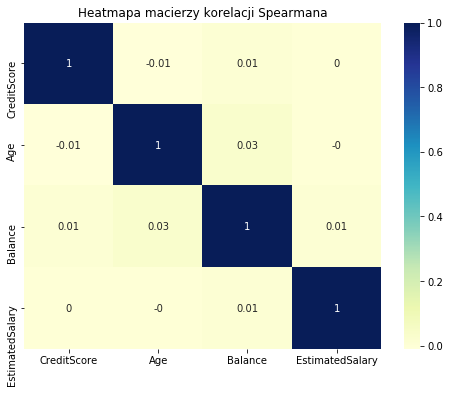

In [11]:
plt.figure(figsize=(8,6))

correl = np.round(df[num].corr(method = 'spearman'), 2)
sns.heatmap(correl, cmap="YlGnBu", annot=True, cbar=True)
plt.title('Heatmapa macierzy korelacji Spearmana')
plt.show()

Zmienne wybinie nieskorelowane ze sobą, brak problemu współliniowości.
###### Test na równość średnich zmiennych ciągłych.

In [12]:
# import funkcji
from hpl import popMeanTest

# podział na "1" i "0"
poszli = df.where(df.Exited == 1).dropna()
zostali = df.where(df.Exited == 0).dropna()


# listy, w których będą zapisane wyniki
stats = []
critics = []
pvals = []
atr = []

for n in num:
    # testowanie
    s, crt, p = popMeanTest(np.array(poszli[n]), np.array(zostali[n]), alternative='two-sided')
    # zapisanie wyników
    stats.append(s)
    critics.append(crt)
    pvals.append(round(p, 5))
    atr.append(n)
    
# zapisanie wyników do obiektu DataFrame
srednie = pd.DataFrame(data = {"zmienna":atr, "U":stats, "wartość krytyczna":critics, "p_value":pvals})

display(srednie)

,zmienna,U,wartość krytyczna,p_value
0,CreditScore,-2.635217,1.959964,0.00841
1,Age,30.425467,1.959964,0.00000
2,Balance,12.473821,1.959964,0.00000
3,EstimatedSalary,1.203620,1.959964,0.22874


"1" i "0" są zróżnicowane pod względem zmiennych ciągłych, za wyjątkiem EstimatedSalary (Rozkład zbliżony do jednostajnego), być może ta zmienna okaże się nieprzydatna.<br/>
##### Pierwszy Logit

In [13]:
from sklearn import preprocessing # label encoding
import statsmodels.api as sm # do logitu
from sklearn.model_selection import train_test_split # podział na zbiory treningowe i testowe
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score # metryki
from sklearn.model_selection import KFold # walidacja K-składana
from sklearn.model_selection import StratifiedKFold # warstowa walidacja K-składana
from sklearn.svm import SVC # estymator SVM
from sklearn import neighbors # estymator KNN
from sklearn.ensemble import RandomForestClassifier # estymator RF
import pickle

In [14]:
# wrapper przygotowany od razu pod Logit, SVM i KNN
def CVTest(dataframe, clf = "logit", nFolds = 5, randomState=2020, y = 'Exited', features = [],
           report = None, imbalanced = True, sample_size = 5000, *args, **kwargs):
    
    # Podzielenie zbioru na foldy
    if imbalanced:
        kf = StratifiedKFold(n_splits = nFolds, shuffle = True, random_state = randomState)
    else:
        kf = KFold(n_splits = nFolds, shuffle = True, random_state = randomState)

    # Stworzenie list z wynikami
    ROCtestResults = []
    PRtestResutls = []
    ROCtrainResults = []
    PRtrainResults = []
    predictions = []
    indices = []
    
    # Pętla do estymacji i walidacji modeli na kolejnych foldach
    for train, test in kf.split(dataframe.index.values, dataframe[y]):
        # Stworzenie modelu
        # ---LOGIT---
        if clf == "logit":
            mod = sm.GLM.from_formula(formula = y + '~' + '+'.join(features), data = dataframe.iloc[train],
                                      family = sm.families.Binomial())
            # Estymacja
            res = mod.fit()
            # Zapisanie predykcji
            predsTrain = res.predict()
            preds = res.predict(dataframe.iloc[test])
        # ---SVM---
        elif clf == 'SVM':
            clf = SVC(probability=True, max_iter=-1, tol=0.001, cache_size=500, *args, **kwargs)
            
            # Zmniejszenie zbioru treningowego
            sampleSize = sample_size
            X = dataframe.iloc[train].sample(sampleSize)
            # Trenowanie modelu
            clf.fit(X[features], X['Exited'])
            # Prognozy dla zbioru treningowego i testowego
            predsTrain = clf.predict_proba(dataframe.iloc[train][features])[:,1]
            preds = clf.predict_proba(dataframe.iloc[test][features])[:,1]
        #---KNN---
        elif clf == 'KNN':
            clf = neighbors.KNeighborsClassifier(*args, **kwargs)
            
            # Trenowanie modelu
            clf.fit(dataframe.iloc[train][features], dataframe.iloc[train][y])
            # Prognozy dla zbioru treningowego i testowego
            predsTrain = clf.predict_proba(dataframe.iloc[train][features])[:,1]
            preds = clf.predict_proba(dataframe.iloc[test][features])[:,1]


        if report == "full":
            train_y = dataframe[y].loc[train]
            test_y = dataframe[y].loc[test]
            print("0 in y_train = {}, 1 in y_train = {} \n0 in y_test = {}, 1 in y_test = {}".format(
            len(train_y[train_y == 0]), len(train_y[train_y == 1]), len(test_y[test_y == 0]), 
            len(test_y[test_y == 1])))
        
        elif report == "half":
            print("Train AUC-ROC:", roc_auc_score(dataframe[y].iloc[train], predsTrain), 
              "Valid AUC-ROC:", roc_auc_score(dataframe[y].iloc[test], preds), 
                 "\nTrain AUC-PR:", average_precision_score(dataframe[y].iloc[train], predsTrain), 
                  "Valid AUC-PR:", average_precision_score(dataframe[y].iloc[test], preds),
                 '\n'+'-'*40)
        else:
            pass

        # Zapisanie wyników ze zbioru walidacyjnego do list
        ROCtestResults.append(roc_auc_score(dataframe[y].iloc[test], preds))
        PRtestResutls.append(average_precision_score(dataframe[y].iloc[test], preds))
        ROCtrainResults.append(roc_auc_score(dataframe[y].iloc[train], predsTrain))
        PRtrainResults.append(average_precision_score(dataframe[y].iloc[train], predsTrain))
        predictions.append(preds.tolist().copy())
        indices.append(dataframe.iloc[test].index.tolist().copy())

    # zwrot list
    return ROCtestResults, PRtestResutls, ROCtrainResults, PRtrainResults, predictions, indices

In [15]:
# Zmienne objaśniające
features_standard = df.columns.tolist()
features_standard.remove('Exited')

In [16]:
ROCtestResults, PRtestResults, ROCtrainResults, PRtrainResults, predictions, indices = CVTest(dataframe = df, features = features_standard)

print('{}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format('-'*30,
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

------------------------------
ROC: 0.7648486062899543
PR: 0.4695414516144849
ROCtrain-test: 0.0029139730121400254
PRtrain-test: 0.0005128827181096196


Zapis pierwszego logitu - posłuży jako benchmark wykonanej pracy.

In [17]:
model_logit_00 = {
    "name":"Logit_00",
    "description":"Model Logitowy zrobiony na szybko, bez pracy nad zmiennymi",
    "specification":'bez regularyzacji',
    "ROCtrainResults":ROCtrainResults.copy(),
    "ROCtestResults":ROCtestResults.copy(),
    "PRtrainResults":PRtrainResults.copy(),
    "PRtestResults":PRtestResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
    "variables":features_standard.copy()
}

# zapis binarny modelu
zapis_logit_00 = False

if zapis_logit_00:
    with open("model_logit_00.p", "wb") as fp:
        pickle.dump(model_logit_00, fp)

Biorąc pod uwagę, że 20% obserwacji to "1" wynik ROC 0.76 nie powala na kolana, patrząc na PR - 0.47 można stwierdzić, że logit na danych w takiej formie nie radzi sobie dobrze z problemem. Wyniki nie są jednak fatalne, być może inżynieria zmiennych przyniesie poprawę. W celu sprawdzenia możliwości zbioru danych, wykorzystane zostaną algorytmy oparte o drzewa decyzyjne - Random Forest i XGB.
##### Przygotowanie zbioru danych dla drzew decyzyjnych (label encoding)

In [18]:
# zmienne kategoryzujące
cat = [i for i in df.columns.tolist() if i not in num]

# Kopiowanie obiektu
dfl = df.copy()
# Słownik zawierający mapy
mapy = {}
for feature in cat:
    # Inicjacja obiektu do kodowania, który będzie przechowywał mapę
    le = preprocessing.LabelEncoder()
    # Dopasowanie kolumny (tworzenie mapy) i od razu jej nałożenie na zmienną, na której dokonane zostało dopasowanie
    dfl[feature] = le.fit_transform(df[feature])
    # Zapis mapy, aby móc odzyskać informację o mapowaniu i oryginalnych wartościach
    mapy[feature] = le
    
features = dfl.columns.tolist()
features.remove('Exited')
print(features)

['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


In [19]:
# Sprawdzenie klas dla Geography
print(mapy['Geography'].classes_)

print('Wszystko ok:', 
pd.Series(df["Geography"].values).equals( # seria z oryginalnego df
    pd.Series(mapy['Geography'].inverse_transform(dfl["Geography"])))) # seria z kopii po odzyskaniu labeli

['France' 'Germany' 'Spain']
Wszystko ok: True


##### Wrapper

In [20]:
def CVTestRFClass(dataframe, nFolds = 5, target = 'Exited', randomState = 2020, debug = False,
                  features = features_standard, saveModels = False , *args, **kwargs):
    
    # walidacja warstowa
    kf = StratifiedKFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # listy do zapisu wyników
    ROCtestResults = []
    ROCtrainResults = []
    PRtestResults = []
    PRtrainResults = []
    predictions = []
    indices = []
    models = []
    
    # Pętla walidująca model
    for train, test in kf.split(dataframe.index.values, dataframe[target]):
        # Przygotowanie estymatora
        clf = RandomForestClassifier(*args, **kwargs, random_state=randomState, n_jobs=-1)
        
        if debug:
            print(clf)
        
        # Trenowanie modelu
        clf.fit(dataframe.iloc[train][features], dataframe.iloc[train][target])

        # Przygotowanie prognoz dla zbioru treningowego i testowego
        predsTrain = clf.predict_proba(dataframe.iloc[train][features])[:,1]
        preds = clf.predict_proba(dataframe.iloc[test][features])[:,1]
        
        # zapis predykcji i indeksów
        predictions.append(preds.tolist().copy())
        indices.append(dataframe.iloc[test].index.tolist().copy())
        
        # Obliczanie metryk
        ROCtrainScore = roc_auc_score((dataframe[target].iloc[train]), predsTrain)
        ROCtestScore = roc_auc_score((dataframe[target].iloc[test]), preds)
        PRtrainScore = average_precision_score(dataframe[target].iloc[train], predsTrain)
        PRtestScore = average_precision_score(dataframe[target].iloc[test], preds)
        
        # Zapisanie wyników metryk do list 
        ROCtrainResults.append(ROCtrainScore)
        ROCtestResults.append(ROCtestScore)
        PRtrainResults.append(PRtrainScore)
        PRtestResults.append(PRtestScore)
        
        # sprawdzenie wyników dla każdego foldu
        if debug:
            print("Train AUC:", ROCtrainScore,
                  "Valid AUC:", ROCtestScore)
            print("Train PR:", PRtrainScore,
                  "Valid PR:", PRtestScore)
            
        # Zapisanie modeli (feature importance)
        if saveModels:
            models.append(clf)
    
    if saveModels:
        return ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, models
    else:
        return ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices

##### Pierwsza estymacja - "suchy przebieg"

In [21]:
# suchy przebieg
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices = CVTestRFClass(dataframe = dfl,
                                                                                                     features = features_standard,
                                                                                                     debug=True)
print(np.mean(ROCtestResults), np.mean(PRtestResults))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=2020, verbose=0,
                       warm_start=False)
Train AUC: 1.0 Valid AUC: 0.8453634594541336
Train PR: 1.0 Valid PR: 0.6645108468346986
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
               

Widać, że istnieją interakcje, które są w stanie poprawić wyniki pierwszego logitu o 0.08 na ROC i 0.2 na PR, to bardzo dużo. Co do RF, wyniki stabilne na foldach, ale ogromne przetrenowanie, należy zbadać jak wrażliwe są wyniki na poszczególne hiperparametry, w szczególności głębokość drzew.  

In [22]:
model_RF_00 = {
    "name":"model_RF_00",
    "description":"Pierwszy model Random Forest",
    "specification":'Parametry standardowe',
    "ROCtrainResults":ROCtrainResults.copy(),
    "ROCtestResults":ROCtestResults.copy(),
    "PRtrainResults":PRtrainResults.copy(),
    "PRtestResults":PRtestResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
    "variables":features_standard.copy()
}

# zapis binarny modelu
zapis_model_RF_00 = False

if zapis_model_RF_00:
    with open("model_RF_00.p", "wb") as fp:
        pickle.dump(model_RF_00, fp)

##### Praca z Random Forest
 - głębokość drzew,

In [23]:
for depth in range(2, 22, 2):
    ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices = CVTestRFClass(dataframe = dfl,
                                                                                                         features = features_standard,
                                                                                                         debug=False,
                                                                                                         max_depth = depth)
    print('Max głębokość drzew: {}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(depth,
                                            np.mean(ROCtestResults),
                                            np.mean(PRtestResults), 
                                           np.mean(ROCtrainResults)-np.mean(ROCtestResults),
                                           np.mean(PRtrainResults)-np.mean(PRtestResults)))
    print('-'*30)

Max głębokość drzew: 2
ROC: 0.8186268144246753
PR: 0.6257623681272931
ROCtrain-test: 0.0034591738091920288
PRtrain-test: 0.003732202842228749
------------------------------
Max głębokość drzew: 4
ROC: 0.8401086248676253
PR: 0.6629969003935138
ROCtrain-test: 0.007652186729079968
PRtrain-test: 0.015583863682430033
------------------------------
Max głębokość drzew: 6
ROC: 0.8520685441822236
PR: 0.6792522799494634
ROCtrain-test: 0.021108570599229104
PRtrain-test: 0.04406852755153645
------------------------------
Max głębokość drzew: 8
ROC: 0.8575757758310445
PR: 0.6907363297111878
ROCtrain-test: 0.050973709357150176
PRtrain-test: 0.09239846647877081
------------------------------
Max głębokość drzew: 10
ROC: 0.8583915872991016
PR: 0.6897690401279911
ROCtrain-test: 0.0969359600449815
PRtrain-test: 0.18361221265913308
------------------------------
Max głębokość drzew: 12
ROC: 0.8560410259751933
PR: 0.6875756121490018
ROCtrain-test: 0.13263582304178212
PRtrain-test: 0.27295561797089785
---

Właściwie powyżej głębokości 14 model już wyjaśnia wszystko na zbiorze treningowym (wynik na zbiorze testowym + przetrenowanie), więc overfitting jest b. duży. Od głębokości 10 widać już spadki, chyba najlepszy przedział do dalszego sprawdzania to 6-10, dla porządku można dać 5-10. W ogóle jest to parametr który najbardziej reguluje przetrenowanie.

In [24]:
for depth in range(5, 11, 1):
    ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices = CVTestRFClass(dataframe = dfl,
                                                                                                         features = features,
                                                                                                         debug=False,
                                                                                                         max_depth = depth)
    print('Max głębokość drzew: {}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(depth,
                                            np.mean(ROCtestResults),
                                            np.mean(PRtestResults), 
                                           np.mean(ROCtrainResults)-np.mean(ROCtestResults),
                                           np.mean(PRtrainResults)-np.mean(PRtestResults)))
    print('-'*30)

Max głębokość drzew: 5
ROC: 0.8483470626008309
PR: 0.6763116133489739
ROCtrain-test: 0.012230207839625695
PRtrain-test: 0.023556621069741324
------------------------------
Max głębokość drzew: 6
ROC: 0.8520685441822236
PR: 0.6792522799494634
ROCtrain-test: 0.021108570599229104
PRtrain-test: 0.04406852755153645
------------------------------
Max głębokość drzew: 7
ROC: 0.8557740124902956
PR: 0.6861393958876552
ROCtrain-test: 0.03351285933582282
PRtrain-test: 0.06322668738155013
------------------------------
Max głębokość drzew: 8
ROC: 0.8575757758310445
PR: 0.6907363297111878
ROCtrain-test: 0.050973709357150176
PRtrain-test: 0.09239846647877081
------------------------------
Max głębokość drzew: 9
ROC: 0.8591130582792059
PR: 0.6917291618671819
ROCtrain-test: 0.07382277803652915
PRtrain-test: 0.13550177318285672
------------------------------
Max głębokość drzew: 10
ROC: 0.8583915872991016
PR: 0.6897690401279911
ROCtrain-test: 0.0969359600449815
PRtrain-test: 0.18361221265913308
-------

najlepszy wybór to chyba między 8 a 9, ale ze względu na przetrenowanie/przyrost wyników lepiej wybrać 8. <br/>
 - wagi (dane są niezbalansowane),

In [25]:
classes = [{0:1, 1:4}, {0:1, 1:3}, {0:1, 1:2}, {0:1, 1:1}, {0:2, 1:1}, {0:3, 1:1}, {0:4, 1:1}]
for class_weight in classes: 
    ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices = CVTestRFClass(dataframe = dfl,
                                                                                                         features = features_standard,
                                                                                                         debug=False,
                                                                                                         class_weight=class_weight,
                                                                                                         max_depth = 8)
    
    print('Wagi: {}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(class_weight,
                                            np.mean(ROCtestResults),
                                            np.mean(PRtestResults), 
                                           np.mean(ROCtrainResults)-np.mean(ROCtestResults),
                                           np.mean(PRtrainResults)-np.mean(PRtestResults)))
    print('-'*30)

Wagi: {0: 1, 1: 4}
ROC: 0.8583964795635687
PR: 0.6767488416704126
ROCtrain-test: 0.05977095049431291
PRtrain-test: 0.11222445358634558
------------------------------
Wagi: {0: 1, 1: 3}
ROC: 0.8584807088907226
PR: 0.6792634737248496
ROCtrain-test: 0.05750487237911561
PRtrain-test: 0.10868525194210654
------------------------------
Wagi: {0: 1, 1: 2}
ROC: 0.8593259747564266
PR: 0.6863927377116349
ROCtrain-test: 0.0543961580272847
PRtrain-test: 0.10169334192778556
------------------------------
Wagi: {0: 1, 1: 1}
ROC: 0.8575757758310445
PR: 0.6907363297111878
ROCtrain-test: 0.050973709357150176
PRtrain-test: 0.09239846647877081
------------------------------
Wagi: {0: 2, 1: 1}
ROC: 0.8552420294316153
PR: 0.6875018739855596
ROCtrain-test: 0.04876903385830489
PRtrain-test: 0.09000735937473248
------------------------------
Wagi: {0: 3, 1: 1}
ROC: 0.8529480070709712
PR: 0.6845894259575501
ROCtrain-test: 0.0480650034202742
PRtrain-test: 0.08789906599719066
------------------------------
Wagi:

co ciekawe najlepsze wyniki na równych wagach,
 - liczba drzew

In [26]:
numOfEstimators = [10, 25, 75, 100, 200, 400, 600, 800, 1000]
for est in numOfEstimators: 
    ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices = CVTestRFClass(dataframe = dfl,
                                                                                                         features = features_standard,
                                                                                                         debug=False,
                                                                                                         n_estimators = est,
                                                                                                        max_depth = 8)
    print('Liczba drzew: {}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(est,
                                            np.mean(ROCtestResults),
                                            np.mean(PRtestResults), 
                                           np.mean(ROCtrainResults)-np.mean(ROCtestResults),
                                           np.mean(PRtrainResults)-np.mean(PRtestResults)))
    print('-'*30)

Liczba drzew: 10
ROC: 0.8500257698024087
PR: 0.6741737907811047
ROCtrain-test: 0.047161220080329636
PRtrain-test: 0.09038200101564908
------------------------------
Liczba drzew: 25
ROC: 0.8537512050724846
PR: 0.6822682185951943
ROCtrain-test: 0.052264219545297586
PRtrain-test: 0.09747892648981027
------------------------------
Liczba drzew: 75
ROC: 0.8566457819452916
PR: 0.6887121254850218
ROCtrain-test: 0.05215344031595648
PRtrain-test: 0.09432923832318096
------------------------------
Liczba drzew: 100
ROC: 0.8575757758310445
PR: 0.6907363297111878
ROCtrain-test: 0.050973709357150176
PRtrain-test: 0.09239846647877081
------------------------------
Liczba drzew: 200
ROC: 0.858707151552532
PR: 0.6923368085323679
ROCtrain-test: 0.050758189745745086
PRtrain-test: 0.09179651622072671
------------------------------
Liczba drzew: 400
ROC: 0.8593930196822368
PR: 0.6927243296718426
ROCtrain-test: 0.05073645389899206
PRtrain-test: 0.09252829683713348
------------------------------
Liczba drz

400-600 drzew daje maksymalny wynik
 - liczba cech w drzewie,

In [27]:
print('pierwiastek liczby cech (automatycznie dobrana liczba cech): {}'.format((len(features_standard))**(1/2)))

pierwiastek liczby cech (automatycznie dobrana liczba cech): 3.1622776601683795


In [28]:
for n in range(1, len(features_standard)+1, 1):
    ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices = CVTestRFClass(dataframe = dfl,
                                                                                                         features = features_standard,
                                                                                                         debug=False,
                                                                                                         max_features = n,
                                                                                                         max_depth = 8,
                                                                                                         n_estimators = 400)
    print('Max liczba cech w drzewie: {}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(n,
                                            np.mean(ROCtestResults),
                                            np.mean(PRtestResults), 
                                           np.mean(ROCtrainResults)-np.mean(ROCtestResults),
                                           np.mean(PRtrainResults)-np.mean(PRtestResults)))
    print('-'*30)

Max liczba cech w drzewie: 1
ROC: 0.8465236317688696
PR: 0.6749544781679238
ROCtrain-test: 0.05682212476715276
PRtrain-test: 0.10426327000235547
------------------------------
Max liczba cech w drzewie: 2
ROC: 0.8554527927751693
PR: 0.6881978354935606
ROCtrain-test: 0.05125442084749454
PRtrain-test: 0.09179448097030685
------------------------------
Max liczba cech w drzewie: 3
ROC: 0.8593930196822368
PR: 0.6927243296718426
ROCtrain-test: 0.05073645389899206
PRtrain-test: 0.09252829683713348
------------------------------
Max liczba cech w drzewie: 4
ROC: 0.8598459969305505
PR: 0.6917247652849449
ROCtrain-test: 0.05252258642844565
PRtrain-test: 0.0971709737865547
------------------------------
Max liczba cech w drzewie: 5
ROC: 0.8586671622984637
PR: 0.6879603199291326
ROCtrain-test: 0.05480844381347383
PRtrain-test: 0.10341806745028759
------------------------------
Max liczba cech w drzewie: 6
ROC: 0.8583049377864993
PR: 0.6880149700674636
ROCtrain-test: 0.05648973433306548
PRtrain-te

3-4, lepiej 3 bo mniejsze przetrenowanie, większe PR, trochę mniejsze ROC, ale PR jest ważniejsze w tym problemie.
 - Min sample split

In [29]:
for minsample in [2, 4, 6, 8, 10, 15, 20, 30]:
    ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices = CVTestRFClass(dataframe = dfl,
                                                                                                         features = features_standard,
                                                                                                         debug=False,
                                                                                                         max_features = 3,
                                                                                                         max_depth = 8,
                                                                                                         n_estimators = 400,
                                                                                                         min_samples_split = minsample)
    print('Min sample split: {}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(minsample,
                                            np.mean(ROCtestResults),
                                            np.mean(PRtestResults), 
                                           np.mean(ROCtrainResults)-np.mean(ROCtestResults),
                                           np.mean(PRtrainResults)-np.mean(PRtestResults)))
    print('-'*30)

Min sample split: 2
ROC: 0.8593930196822368
PR: 0.6927243296718426
ROCtrain-test: 0.05073645389899206
PRtrain-test: 0.09252829683713348
------------------------------
Min sample split: 4
ROC: 0.8592193948102039
PR: 0.6923618007125382
ROCtrain-test: 0.049898014902803545
PRtrain-test: 0.09023824862513374
------------------------------
Min sample split: 6
ROC: 0.8596659096513022
PR: 0.6927350490170987
ROCtrain-test: 0.04836420602300473
PRtrain-test: 0.0874279240154846
------------------------------
Min sample split: 8
ROC: 0.8590176495698779
PR: 0.692367846556104
ROCtrain-test: 0.0478120834138942
PRtrain-test: 0.08504862690904225
------------------------------
Min sample split: 10
ROC: 0.8588193530457661
PR: 0.6926257964063905
ROCtrain-test: 0.04684345784246757
PRtrain-test: 0.08189202163793874
------------------------------
Min sample split: 15
ROC: 0.8593002829852896
PR: 0.69374865845274
ROCtrain-test: 0.04457382097676155
PRtrain-test: 0.0762968237834708
------------------------------
M

In [30]:
for minsample in range(10,21,1):
    ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices = CVTestRFClass(dataframe = dfl,
                                                                                                         features = features_standard,
                                                                                                         debug=False,
                                                                                                         max_features = 3,
                                                                                                         max_depth = 8,
                                                                                                         n_estimators = 200,
                                                                                                         min_samples_split = minsample)
    print('Min sample split: {}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(minsample,
                                            np.mean(ROCtestResults),
                                            np.mean(PRtestResults), 
                                           np.mean(ROCtrainResults)-np.mean(ROCtestResults),
                                           np.mean(PRtrainResults)-np.mean(PRtestResults)))
    print('-'*30)

Min sample split: 10
ROC: 0.8585891795692044
PR: 0.6921095481965164
ROCtrain-test: 0.046822687614536895
PRtrain-test: 0.08166645503598802
------------------------------
Min sample split: 11
ROC: 0.8591072192787148
PR: 0.6931745538196014
ROCtrain-test: 0.04634805133472142
PRtrain-test: 0.08011366751280169
------------------------------
Min sample split: 12
ROC: 0.8592276174898441
PR: 0.6931934473974278
ROCtrain-test: 0.04570378369252026
PRtrain-test: 0.07887564680503079
------------------------------
Min sample split: 13
ROC: 0.85911186898708
PR: 0.6929983597641722
ROCtrain-test: 0.04539644009178301
PRtrain-test: 0.07812584237961451
------------------------------
Min sample split: 14
ROC: 0.859502251306847
PR: 0.6930146417887191
ROCtrain-test: 0.04501333214652836
PRtrain-test: 0.07781161786728441
------------------------------
Min sample split: 15
ROC: 0.8591818313693361
PR: 0.6931717394488925
ROCtrain-test: 0.0448083159525996
PRtrain-test: 0.0768051052393054
---------------------------

Najlepsze wyniki 11-15.
 - wielkość ostatniego liścia,

In [31]:
for leaf in range(1,16,1):
    ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices = CVTestRFClass(dataframe = dfl,
                                                                                                         features = features_standard,
                                                                                                         debug=False,
                                                                                                         max_features = 3,
                                                                                                         max_depth = 8,
                                                                                                         n_estimators = 400,
                                                                                                         min_samples_split = 15,
                                                                                                         min_samples_leaf = leaf)
    print('Min w liściu: {}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(leaf,
                                            np.mean(ROCtestResults),
                                            np.mean(PRtestResults), 
                                           np.mean(ROCtrainResults)-np.mean(ROCtestResults),
                                           np.mean(PRtrainResults)-np.mean(PRtestResults)))
    print('-'*30)

Min w liściu: 1
ROC: 0.8593002829852896
PR: 0.69374865845274
ROCtrain-test: 0.04457382097676155
PRtrain-test: 0.0762968237834708
------------------------------
Min w liściu: 2
ROC: 0.8595738327491247
PR: 0.6926685728516251
ROCtrain-test: 0.04428722149127118
PRtrain-test: 0.0763146992616901
------------------------------
Min w liściu: 3
ROC: 0.8597306955676258
PR: 0.6930146002301572
ROCtrain-test: 0.04416338980625145
PRtrain-test: 0.0753918879547878
------------------------------
Min w liściu: 4
ROC: 0.8599487969524061
PR: 0.693056028989251
ROCtrain-test: 0.04408739197956546
PRtrain-test: 0.07452710222409531
------------------------------
Min w liściu: 5
ROC: 0.8599379469418847
PR: 0.692932192417014
ROCtrain-test: 0.04396761481455547
PRtrain-test: 0.07398226702119182
------------------------------
Min w liściu: 6
ROC: 0.8601126422863944
PR: 0.6927436227527284
ROCtrain-test: 0.04354560541274033
PRtrain-test: 0.07288084184809684
------------------------------
Min w liściu: 7
ROC: 0.859552

Nie ma profitu ze stawiania ograniczeń.
 - min impiurity,

In [32]:
for imp in [0.001, 0.003, 0.006, 0.009, 0.01, 0.03, 0.06, 0.09, 0.1, 0.3, 0.6, 0.9]:
    ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices = CVTestRFClass(dataframe = dfl,
                                                                                                         features = features_standard,
                                                                                                         debug=False,
                                                                                                         max_features = 3,
                                                                                                         max_depth = 8,
                                                                                                         n_estimators = 400,
                                                                                                         min_samples_split = 15,
                                                                                                         min_impurity_decrease = imp)
    print('Min impurity: {}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(imp,
                                            np.mean(ROCtestResults),
                                            np.mean(PRtestResults), 
                                           np.mean(ROCtrainResults)-np.mean(ROCtestResults),
                                           np.mean(PRtrainResults)-np.mean(PRtestResults)))
    print('-'*30)

Min impurity: 0.001
ROC: 0.8462121567367701
PR: 0.672487204727606
ROCtrain-test: 0.0075840729623932734
PRtrain-test: 0.013636400587145658
------------------------------
Min impurity: 0.003
ROC: 0.8303594057060183
PR: 0.647090628679899
ROCtrain-test: 0.003840439423488773
PRtrain-test: 0.005348478035750226
------------------------------
Min impurity: 0.006
ROC: 0.8125370745701807
PR: 0.6228078050867633
ROCtrain-test: 0.004075302243756518
PRtrain-test: 0.002100680092675611
------------------------------
Min impurity: 0.009
ROC: 0.8126372732293115
PR: 0.6023569508361561
ROCtrain-test: 0.002137138230262403
PRtrain-test: 0.0019180779332668152
------------------------------
Min impurity: 0.01
ROC: 0.8093838376995894
PR: 0.5938271543908907
ROCtrain-test: 0.0021149767663016794
PRtrain-test: 0.002337021740230427
------------------------------
Min impurity: 0.03
ROC: 0.7364408632473628
PR: 0.4150729434192545
ROCtrain-test: 0.000794913911077999
PRtrain-test: 0.0005629223373335157
-----------------

Min impurity chyba nie ma co ruszać, to są wartości bardzo małe, nie ma się co tym przejmować.<br/>
 - min_weight_fraction_leaf.

In [33]:
for mwfl in [0.0000001, 0.0000003, 0.0000006]:
    ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices = CVTestRFClass(dataframe = dfl,
                                                                                                         features = features_standard,
                                                                                                         debug=False,
                                                                                                         max_features = 3,
                                                                                                         max_depth = 8,
                                                                                                         n_estimators = 400,
                                                                                                         min_samples_split = 15,
                                                                                                         min_weight_fraction_leaf = mwfl)
    print('Min ułamek po splicie: {}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(mwfl,
                                            np.mean(ROCtestResults),
                                            np.mean(PRtestResults), 
                                           np.mean(ROCtrainResults)-np.mean(ROCtestResults),
                                           np.mean(PRtrainResults)-np.mean(PRtestResults)))
    print('-'*30)

Min ułamek po splicie: 1e-07
ROC: 0.8593002829852896
PR: 0.69374865845274
ROCtrain-test: 0.04457382097676155
PRtrain-test: 0.0762968237834708
------------------------------
Min ułamek po splicie: 3e-07
ROC: 0.8593002829852896
PR: 0.69374865845274
ROCtrain-test: 0.04457382097676155
PRtrain-test: 0.0762968237834708
------------------------------
Min ułamek po splicie: 6e-07
ROC: 0.8593002829852896
PR: 0.69374865845274
ROCtrain-test: 0.04457382097676155
PRtrain-test: 0.0762968237834708
------------------------------


Min frakcję po splicie też lepiej zostawić.<br/>
domyślna wartość 1 w 1 liściu była najlepsza.<br/>
Podsumowując najlepsze wyniki dla:
 - 400 drzew,
 - 8 głębokości,
 - przy wykorzystaniu max 3 cech,
 - dzieleniu minimum 15 elementowego sampla,
 - przy minimalnie 1 obserwacji w 1 liściu,
 - wagach 1:1

Wynik poniżej.

In [34]:
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices = CVTestRFClass(dataframe = dfl,
                                                                                                     features = features_standard,
                                                                                                     debug=False,
                                                                                                     max_features = 3,
                                                                                                     max_depth = 8,
                                                                                                     n_estimators = 400,
                                                                                                     min_samples_split = 15)

print('Najlepszy las\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
                                        np.mean(ROCtestResults),
                                        np.mean(PRtestResults), 
                                       np.mean(ROCtrainResults)-np.mean(ROCtestResults),
                                       np.mean(PRtrainResults)-np.mean(PRtestResults)))

model_RF_01 = {
    "name":"model_RF_01",
    "description":"Model RF z sekwencyjnie dobieranymi hiperparametrami z surowymi danymi",
    "specification":'n_estimators=400, max_depth=8, max_features=3, min_samples_split=15, min_samples_leaf=1',
    "ROCtrainResults":ROCtrainResults.copy(),
    "ROCtestResults":ROCtestResults.copy(),
    "PRtrainResults":PRtrainResults.copy(),
    "PRtestResults":PRtestResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
    "variables":features_standard.copy()
}

# zapis binarny modelu
zapis_model_RF_01 = False

if zapis_model_RF_01:
    with open("model_RF_01.p", "wb") as fp:
        pickle.dump(model_RF_01, fp)

Najlepszy las
ROC: 0.8593002829852896
PR: 0.69374865845274
ROCtrain-test: 0.04457382097676155
PRtrain-test: 0.0762968237834708


##### Random Search
Poniżej znajduje się kod, przy pomocy którego znalezione zostały najlepsze parametry, z uwagi na czas wykonania nie jest on uruchomiony w niniejszym notatniku. Ten notatnik jest notatnikiem szykowanym dla czytelnika i zawiera uporządkowane informacje i kody z notatników roboczych.

In [35]:
'''import random

# df z wynikami
rstls = pd.DataFrame(columns = ["max_depth", "max_features", "min_samples_split", "min_samples_leaf", 
                               "ROCtest", "ROCtrain-test", "PRtest", "PRtrain-PRtest"])

# pętla iterująca
for k in range(50):
    # słownik parametrów
    params = {
        "max_depth" : random.randint(5, 10),
        "max_features" : random.randint(3, 5),
        "min_samples_split" : random.randint(11, 15),
    }
    # Wartość min_samples_leaf musi być mniejsza niż min_samples_split
    params["min_samples_leaf"] = random.randint(1, params["min_samples_split"])
    
    # Estymacja modelu dla wylosowanych hiperparametrów
    ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices = CVTestRFClass(
        dataframe = dfl,
        features = features,
        n_estimators = 400, 
        max_depth = params["max_depth"],
        max_features = params["max_features"],
        min_samples_split = params["min_samples_split"],
        min_samples_leaf = params["min_samples_leaf"])
    
    # zapis wyniku
    rstls = rstls.append(other = pd.DataFrame(data = np.array([params["max_depth"], params["max_features"], params["min_samples_split"],
                        params["min_samples_leaf"], np.mean(ROCtestResults),
                           np.mean(ROCtrainResults)-np.mean(ROCtestResults), np.mean(PRtestResults),
                           np.mean(PRtrainResults)-np.mean(PRtestResults)]).reshape(1, -1), columns = rstls.columns.tolist()), ignore_index=True)
    
    # wyświetlenie wyniku bieżącej iteracji
    print(np.round(rstls.iloc[k-1, :], 5).to_dict())
    print('-'*30)
    
    # wyświetlenie dotychczasowe top 5 co 10 iteracji
    if k > 1 and (k+1) % 10 == 0:    
        print("\n Top 5:")
        display(rstls.sort_values(by = "PRtest", ascending = False).head(5))'''


'import random\n\n# df z wynikami\nrstls = pd.DataFrame(columns = ["max_depth", "max_features", "min_samples_split", "min_samples_leaf", \n                               "ROCtest", "ROCtrain-test", "PRtest", "PRtrain-PRtest"])\n\n# pętla iterująca\nfor k in range(50):\n    # słownik parametrów\n    params = {\n        "max_depth" : random.randint(5, 10),\n        "max_features" : random.randint(3, 5),\n        "min_samples_split" : random.randint(11, 15),\n    }\n    # Wartość min_samples_leaf musi być mniejsza niż min_samples_split\n    params["min_samples_leaf"] = random.randint(1, params["min_samples_split"])\n    \n    # Estymacja modelu dla wylosowanych hiperparametrów\n    ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices = CVTestRFClass(\n        dataframe = dfl,\n        features = features,\n        n_estimators = 400, \n        max_depth = params["max_depth"],\n        max_features = params["max_features"],\n        min_samples_split = param

Poniższy kod również nie zostanie uruchomiony w tym notatniku, zamieszczony jednak został archiwalny screen.

In [36]:
'''# krzywa wyników random search
plt.plot([x for x in sorted(rstls.PRtest.tolist(), reverse=True)])
plt.title('Precision recall score random search')
plt.show()'''

"# krzywa wyników random search\nplt.plot([x for x in sorted(rstls.PRtest.tolist(), reverse=True)])\nplt.title('Precision recall score random search')\nplt.show()"

![alt text](img\RS.PNG)

Zapis najlepszego modelu Random Forest.

In [37]:
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, models = CVTestRFClass(
    dataframe = dfl,
    features = features_standard,
    debug=False,
    max_features = 4,
    max_depth = 10,
    n_estimators = 400,
    min_samples_split = 15,
    min_samples_leaf = 9,
    saveModels = True)

print('las po random search\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

model_RF_02 = {
    "name":"model_RF_02",
    "description":"Model RF z losowanymi hiperparametrami z surowymi danymi",
    "specification":'n_estimators=400, max_depth=10, max_features=4, min_samples_split=15, min_samples_leaf=9',
    "ROCtrainResults":ROCtrainResults.copy(),
    "ROCtestResults":ROCtestResults.copy(),
    "PRtrainResults":PRtrainResults.copy(),
    "PRtestResults":PRtestResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
    "variables":features_standard.copy()
}

zapis2_model_RF_02 = False

if zapis2_model_RF_02:
    with open("model_RF_02.p", "wb") as fp:
        pickle.dump(model_RF_02, fp)

las po random search
ROC: 0.8617968197816749
PR: 0.6954932334652437
ROCtrain-test: 0.07096158949241005
PRtrain-test: 0.11676165474571853


##### Porównanie dotychczasowych modeli.

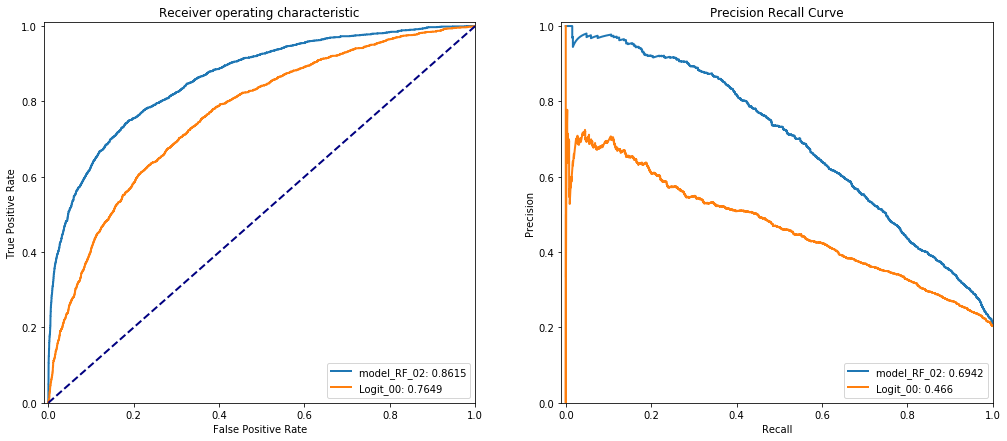

In [38]:
from sklearn.metrics import roc_curve, precision_recall_curve
from hpl import plotROCsPRs

'''def plotROCsPRs(results):
    
    f, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (17, 7))
    
    for true, pred, label in results:
        # Obliczenie punktów potrzebnych do narysowania krzywych ROC i PR
        # funkcja roc_curve zwarca trzy serie danych, fpr, tpr oraz poziomy progów odcięcia
        fpr, tpr, thresholds = roc_curve(true, pred)
        precision, recall, thresholds = precision_recall_curve(true, pred)
        # Obliczamy pole powierzchni pod krzywymi
        rocScore = round(roc_auc_score(true, pred), 4)
        average_precision = round(average_precision_score(true, pred), 4)
        
        # Grubość krzywych
        lw = 2
        
        # Rysujemy krzywą ROC i PR
        ax[0].plot(fpr, tpr, lw = lw, label = '{}: {}'.format(label, rocScore))
        ax[1].plot(recall, precision, lw=lw, label='{}: {}'.format(label, average_precision))
    
    # Rysujemy krzywą 45 stopni jako punkt odniesienia
    ax[0].plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
    
    
    ax[0].set_xlim([-0.01, 1.0])
    ax[0].set_ylim([0.0, 1.01])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver operating characteristic')
    ax[0].legend(loc = "lower right")
    
    ax[1].set_xlim([-0.01, 1.0])
    ax[1].set_ylim([0.0, 1.01])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision Recall Curve')
    ax[1].legend(loc = "lower right")
    
    plt.show()'''

res2plot = []
true = df.Exited.astype(int).sort_index()
for result in [model_RF_02, model_logit_00]:
    #true = df.Exited.sort_index()
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))
    
plotROCsPRs(res2plot)

Wyniki na wykresach są inne niż te uzyskane podczas estymacji!

In [39]:
print('ROC train\n', model_RF_02['ROCtrainResults'])
print('ROC test\n', model_RF_02['ROCtestResults'])
print('PR train\n', model_RF_02['PRtrainResults'])
print('PR test\n', model_RF_02['PRtestResults'])
print(len(model_RF_02['predictions']))
print(len(model_RF_02['indices']))

ROC train
 [0.9333049666137007, 0.9327985281680851, 0.9339200238849669, 0.9318178578651848, 0.9319506698384876]
ROC test
 [0.8589531604098927, 0.8649713025913884, 0.8663039002022053, 0.8492344424547814, 0.8695212932501067]
PR train
 [0.8141606601668234, 0.8121078289783956, 0.8153565642390095, 0.8116055812376313, 0.8080438064329512]
PR test
 [0.6875712550961134, 0.704273719179257, 0.6806425965074488, 0.6820250800761766, 0.7229535164672228]
5
5


In [40]:
AVPR = []
for i in [0,1,2,3,4]:
    print('PR dla {} foldu'.format(i+1))
    AVPR.append(average_precision_score(df.iloc[model_RF_02['indices'][i]].Exited.values,
                            pd.Series(data = model_RF_02['predictions'][i], index = model_RF_02['indices'][i]).values,
                                       average = 'weighted'))
    print(AVPR[i])
    print('-'*30)
print('Średnia średnich PR {}'.format(np.mean(AVPR)))

PR dla 1 foldu
0.6875712550961134
------------------------------
PR dla 2 foldu
0.704273719179257
------------------------------
PR dla 3 foldu
0.6806425965074488
------------------------------
PR dla 4 foldu
0.6820250800761766
------------------------------
PR dla 5 foldu
0.7229535164672228
------------------------------
Średnia średnich PR 0.6954932334652437


In [41]:
print('Globalna średnia PR {}'.format(
    average_precision_score(df.Exited.sort_index(), 
                            pd.Series(data = sum(model_RF_02['predictions'], []),
                                      index = sum(model_RF_02['indices'], [])).sort_index())))

Globalna średnia PR 0.6942182141702111


W przypadku niezbalansowanego zbioru danych średnia średnich wyników nie jest równa średniemu wynikowi globalnemu. **Porównania w niniejszym projekcie zostaną oparte na średnich średnich** w myśl artykułu: <br/>
George'a Formana i Martina Scholza "Apples-to-Apples in Cross-Validation Studies: Pitfalls in Classifier Performance Measurement" (2009).
##### Feature importance Random Forest

In [42]:
for i in range(5):
    imps = list(zip(models[i].feature_importances_, features))
    imps.sort(reverse = True)
    print('Fold {}\n'.format(i+1), np.array(imps))
    print('-'*30)

Fold 1
 [['0.3567167912155127' 'Age']
 ['0.25654318512381274' 'NumOfProducts']
 ['0.0931357089912578' 'Balance']
 ['0.079552862561104' 'IsActiveMember']
 ['0.05804927590715647' 'EstimatedSalary']
 ['0.05474981236011291' 'CreditScore']
 ['0.04249883743629588' 'Geography']
 ['0.032752154691059326' 'Tenure']
 ['0.01942474263844131' 'Gender']
 ['0.006576629075247053' 'HasCrCard']]
------------------------------
Fold 2
 [['0.35466767849716' 'Age']
 ['0.25809830280973356' 'NumOfProducts']
 ['0.09792824432447951' 'Balance']
 ['0.0819721842608887' 'IsActiveMember']
 ['0.05622180749597602' 'EstimatedSalary']
 ['0.05539676385601843' 'CreditScore']
 ['0.04239471192217068' 'Geography']
 ['0.029266033929154393' 'Tenure']
 ['0.017545845297441864' 'Gender']
 ['0.006508427606976707' 'HasCrCard']]
------------------------------
Fold 3
 [['0.3539015018702536' 'Age']
 ['0.25059973367904803' 'NumOfProducts']
 ['0.09278335464071007' 'Balance']
 ['0.09165895057857634' 'IsActiveMember']
 ['0.0588107711537640

Zdecydowanie **Age** i **NumOfProducts** to są kluczowe zmienne, widać największe parametry **(.35-.25)**<br/>
**Balance** i **IsActiveMember** są dużo niższe, ale blisko siebie **(.07-.09)**<br/>
**CreditScore** i **EstimatedSalary** czasem zmienają kolejność **(.05-.06)**<br/>
**Geograpy**, **Tenure** i **Gender** mają jeszcze części setne, ale są to wartości najmniejsze **(.01-.04)**<br/>
**HasCrCard** to już wartości tysięczne, ta cecha jest najmniej istotna **(.006)**<br/>
#### Eksperyment z usunięciem HasCrCard z RandomForest

In [43]:
# usunięcie HasCrCard z listy zmiennych
ftrs = features_standard.copy()
ftrs.remove('HasCrCard')

# estymacja
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, models = CVTestRFClass(
    dataframe = dfl,
    features = ftrs,
    debug=False,
    max_features = 4,
    max_depth = 10,
    n_estimators = 400,
    min_samples_split = 15,
    min_samples_leaf = 9,
    saveModels = True)

# druk
print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format(
    np.mean(ROCtestResults),
    np.mean(PRtestResults),
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

ROC: 0.8619208254857057
PR: 0.6943522667526266
ROCtrain-test: 0.0714086710940357
PRtrain-test: 0.11884660935224867


Usunięcie HasCrCard nie wpływa pozytynwnie na model, Random Forest znajduje zastosowanie dla tej zmiennej, nie należy jej więc usuwać.
### XGB

In [44]:
# biblioteki
from random import shuffle
from random import randint
import xgboost as xgb
import time
from operator import itemgetter

In [45]:
def run_xgb(train, validate, features = features_standard, target = 'Exited', # argumenty obowiązkowe
            eta=0.03, max_depth=7, subsample = 0.7, colsample_bytree = 0.7, # hiperparametry
            colsample_bylevel=1,lambdaX = 1, alpha=0, gamma=0, min_child_weight=0, # hiperparametry
            rate_drop = 0.2, skip_drop=0.5, # hiperparametry
            num_boost_round = 1000, early_stopping_rounds = 50, # hiperparametry
            debug=True, eval_metric= ["auc", "aucpr"], objective = "binary:logistic", # konfiguracja
            seed=2017, booster = "gbtree", tree_method="exact", grow_policy="depthwise"): # konfiguracja

   
    start_time = time.time()
    paramList= ['eta', 'max_depth',
         'subsample', 'colsample_bytree', 'colsample_bylevel',
         'lambdaX', 'alpha', 'gamma', 'min_child_weight',
         'num_boost_round', 'early_stopping_rounds',
         'rate_drop', 'skip_drop',
         'eval_metric', 'objective', 
          'seed', 'booster', 'tree_method', 'grow_policy']
    
    # Stworzenie słownika do przekazania do XGB
    params = dict()
    for param in paramList:
        params[param]=eval(param)
        
    if (debug and debug != 'half'):
        for param in paramList:
            print(param, eval(param), end=", ")
        print('\nLength train:', len(train.index))
        print('Length valid:', len(validate.index))

    # Automatyczne przekazanie liczby klas dla wielu poziomów klasyfikacji
    if (params["objective"]=="multi:softmax" or params["objective"]=="multi:softprob"):
        params["num_class"]=train[target].nunique()
    params["silent"]=1
    
    # XGB wymaga w słowniku parametrów słowa kluczowego lambda, poniżej workaround
    params["lambda"]=lambdaX
    
    # Przekształcenie zbiorów do struktury DMatrix
    dtrain = xgb.DMatrix(train[features].values, train[target].values, feature_names=train[features].columns.values)
    dvalid = xgb.DMatrix(validate[features].values, validate[target].values, feature_names=validate[features].columns.values)

    # Stworzenie listy zbiorów do ealuacji
    evals = [(dtrain, 'train'), (dvalid, 'valid')]
    
    # Stworzenie zmiennej słownikowej do przekazania
    train_history = dict()

    # Uruchomienie algorytmu trenującego
    gbm = xgb.train(params, dtrain, 
                    num_boost_round, early_stopping_rounds=early_stopping_rounds,
                    evals=evals, evals_result=train_history, verbose_eval=debug)
    
    # Obliczenia statystyk i dodatkowych wartości
    score = gbm.best_score

    # Przekształcenie historii trenowania do obiektu DataFrame
    trainHistory = dict()
    for key in train_history.keys():
        for metric in train_history[key].keys():
            trainHistory[key+metric.upper()]=train_history[key][metric]
    train_history = pd.DataFrame(trainHistory)

    # Zapis przewidywanych wartości dla zbioru walidacyjnego dla najlepszej (z punktu widzenia walidacji) iteracji
    trainPred = gbm.predict(dtrain, ntree_limit=gbm.best_iteration)
    testPred = gbm.predict(dvalid, ntree_limit=gbm.best_iteration)

    # Przygotowanie posortowanej listy dla ważności zmiennych, zamaist słownika
    imp = gbm.get_fscore()
    imp = sorted(imp.items(), key=itemgetter(1), reverse=True)

    impFig = None
    if debug:
        print('Czas trenowania: {} minut'.format(round((time.time() - start_time)/60, 2)))
        # Skorzystanie z wbudowanej funkcji wizualizującej ważnośc zmiennych
        impFig, ax = plt.subplots()
        xgb.plot_importance(gbm, ax=ax)
        
    return score, trainPred, testPred, train_history, impFig, imp

Jeden split

In [46]:
test_size = 0.2
X_train, X_valid = train_test_split(dfl, test_size=test_size, random_state=2017, stratify=df['Exited'].values)

Pierwsze uruchomienie na jednym splicie

eta 0.03, max_depth 7, subsample 0.7, colsample_bytree 0.7, colsample_bylevel 1, lambdaX 1, alpha 0, gamma 0, min_child_weight 0, num_boost_round 1000, early_stopping_rounds 50, rate_drop 0.2, skip_drop 0.5, eval_metric ['auc', 'aucpr'], objective binary:logistic, seed 2017, booster gbtree, tree_method exact, grow_policy depthwise, 
Length train: 8000
Length valid: 2000
[0]	train-auc:0.810448	train-aucpr:0.608273	valid-auc:0.744801	valid-aucpr:0.503974
Multiple eval metrics have been passed: 'valid-aucpr' will be used for early stopping.

Will train until valid-aucpr hasn't improved in 50 rounds.
[1]	train-auc:0.878202	train-aucpr:0.724028	valid-auc:0.834145	valid-aucpr:0.634739
[2]	train-auc:0.884504	train-aucpr:0.737422	valid-auc:0.848518	valid-aucpr:0.666483
[3]	train-auc:0.883455	train-aucpr:0.738809	valid-auc:0.850534	valid-aucpr:0.677104
[4]	train-auc:0.889917	train-aucpr:0.746436	valid-auc:0.847381	valid-aucpr:0.658008
[5]	train-auc:0.887806	train-aucpr:0.74251	valid-auc:0.84463

[91]	train-auc:0.931236	train-aucpr:0.827825	valid-auc:0.859264	valid-aucpr:0.68966
[92]	train-auc:0.93158	train-aucpr:0.828659	valid-auc:0.859687	valid-aucpr:0.689797
[93]	train-auc:0.931979	train-aucpr:0.829503	valid-auc:0.859598	valid-aucpr:0.690098
[94]	train-auc:0.932576	train-aucpr:0.830415	valid-auc:0.859402	valid-aucpr:0.690336
[95]	train-auc:0.932951	train-aucpr:0.831136	valid-auc:0.859224	valid-aucpr:0.689738
[96]	train-auc:0.933665	train-aucpr:0.832438	valid-auc:0.859393	valid-aucpr:0.690077
[97]	train-auc:0.933983	train-aucpr:0.833262	valid-auc:0.859554	valid-aucpr:0.690205
[98]	train-auc:0.934108	train-aucpr:0.833473	valid-auc:0.859787	valid-aucpr:0.690782
[99]	train-auc:0.934519	train-aucpr:0.83388	valid-auc:0.859758	valid-aucpr:0.690697
[100]	train-auc:0.934635	train-aucpr:0.834374	valid-auc:0.859827	valid-aucpr:0.690782
[101]	train-auc:0.935194	train-aucpr:0.835431	valid-auc:0.859628	valid-aucpr:0.690501
[102]	train-auc:0.935585	train-aucpr:0.836286	valid-auc:0.859932	v

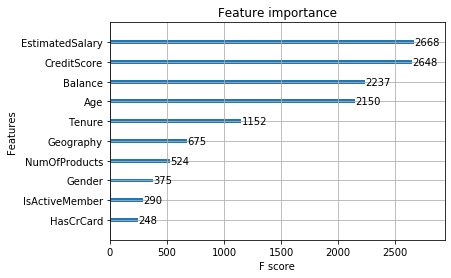

In [47]:
score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features_standard, 'Exited', early_stopping_rounds=50, debug = True)

Bez strojenia wynik bardzo zbliżony do Random Forest (ROC mniejsze o ok 0.02, PR o 0.002).

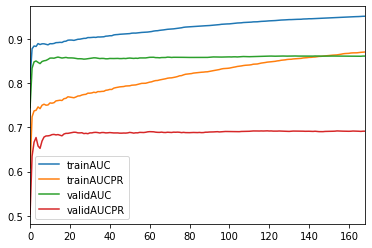

In [48]:
train_history.plot()
plt.show()

##### Praca z XGB
 - głębokość drzew,

5 0.692095
6 0.693924
7 0.692192
8 0.691088
9 0.690604
10 0.689705


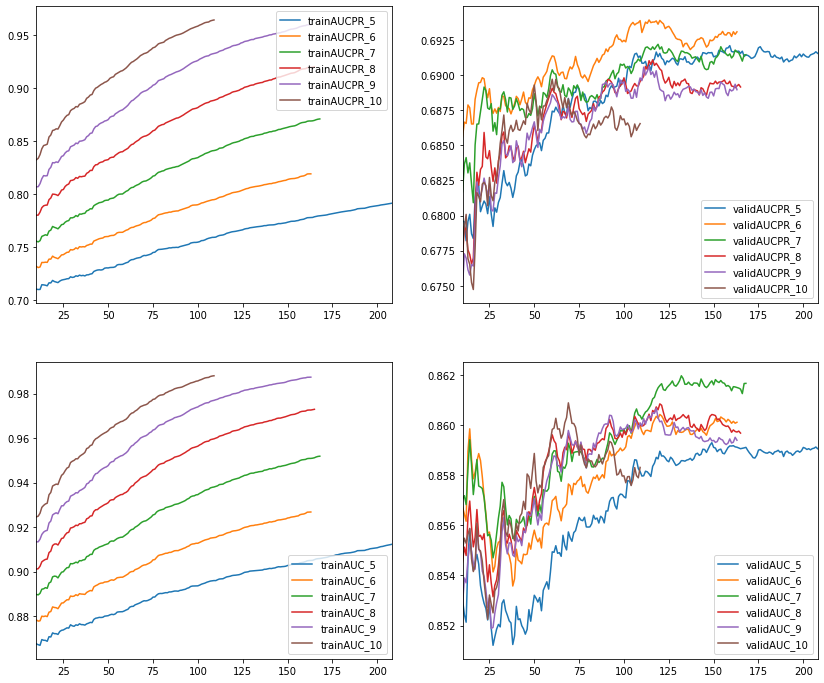

In [49]:
# Przygotowanie obiektu dla wyników
resHists = dict()
rang = range(5,11,1)
# Sprawdzenie modelu dla różnych wartości hiperparametru:
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features_standard, 'Exited',
                                                                     max_depth=x, early_stopping_rounds=50, debug=False)
    # zapisanie historii
    resHists[x]=train_history
    print(x, score)
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# wykresy historii po 10 iteracji
for x in rang:
    resHists[x][['trainAUCPR']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0, 0])
    resHists[x][['validAUCPR']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[0, 1])
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1, 0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[10:].plot(ax=ax[1, 1])
plt.show()

Zdecydowanie głębokość 6 najlepsza pod względem PR, biorąc pod uwagę też AUC, można się zastanawiać nad zakresem 5-8
 -  uział wierszy,

0.3 0.689767
0.4 0.685722
0.5 0.688284
0.6 0.692625
0.7 0.693924
0.8 0.695466
0.9 0.694705


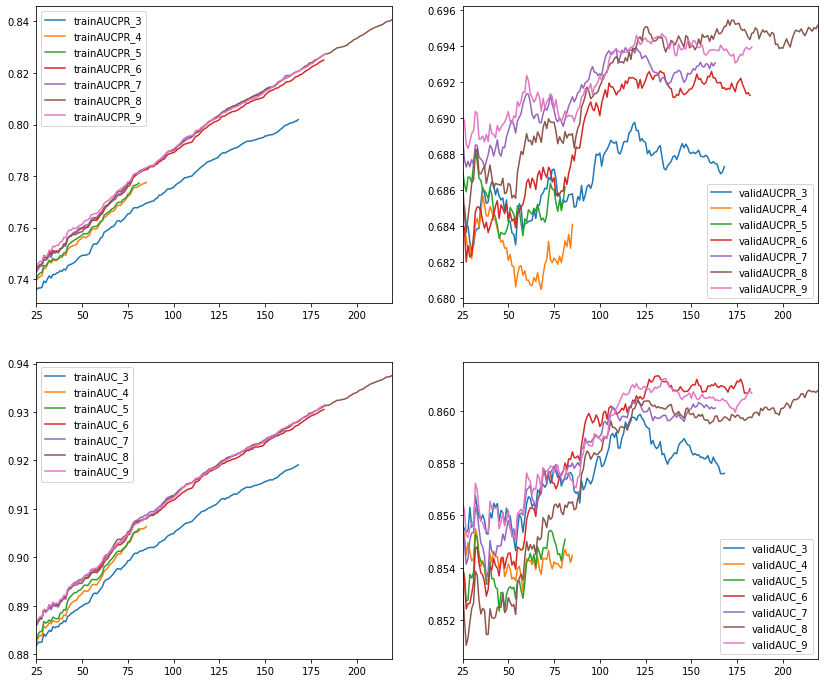

In [50]:
# Przygotowanie obiektu dla wyników
resHists = dict()
rang = range(3,10)
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features_standard, "Exited",
                                                          max_depth=6,  subsample=x/10,
                                                          early_stopping_rounds=50, debug=False)
    # zapisanie historii
    resHists[x]=train_history
    print(x/10, score)
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
## wykresy historii po 25 obserwacji
for x in rang:
    resHists[x][['trainAUCPR']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[0, 0])
    resHists[x][['validAUCPR']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[0, 1])
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[1, 0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[1, 1])
plt.show()

Pod względem PR 0.8 zdecydowanie najlepsze, biorąc pod uwagę ROC można się zastanawiać nad zakresem 6-9.
 - udział kolumn,

0.3 0.683685
0.4 0.682665
0.5 0.694542
0.6 0.696712
0.7 0.695466
0.8 0.696763
0.9 0.697897


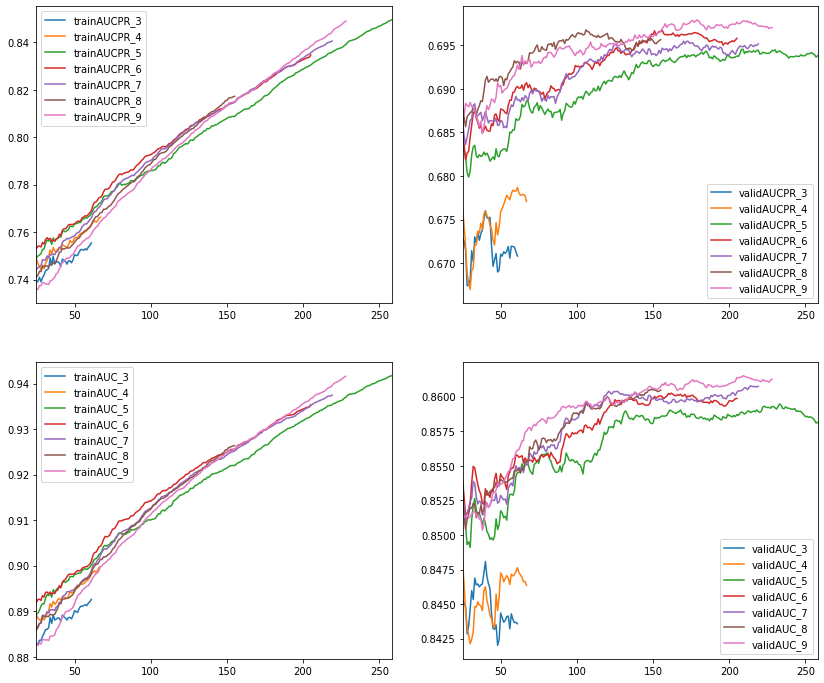

In [51]:
# Przygotowanie obiektu dla wyników
resHists = dict()
rang = range(3,10)
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features_standard, "Exited",
                                                          max_depth=6, subsample=0.8, colsample_bytree=x/10,
                                                          early_stopping_rounds=50, debug=False)
    # zapisanie historii
    resHists[x]=train_history
    print(x/10, score)
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
## wykresy historii po 25 obserwacji
for x in rang:
    resHists[x][['trainAUCPR']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[0, 0])
    resHists[x][['validAUCPR']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[0, 1])
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[1, 0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[1, 1])
plt.show()

dostępność 90% kolumn to najlepszy wynik, co oznacza, że większość zmiennych jest przydatna.
 - regularyzacja L2,

0 0.694176
1 0.697897
4 0.695512
9 0.692289
16 0.689409
25 0.68825
36 0.685635
49 0.684489


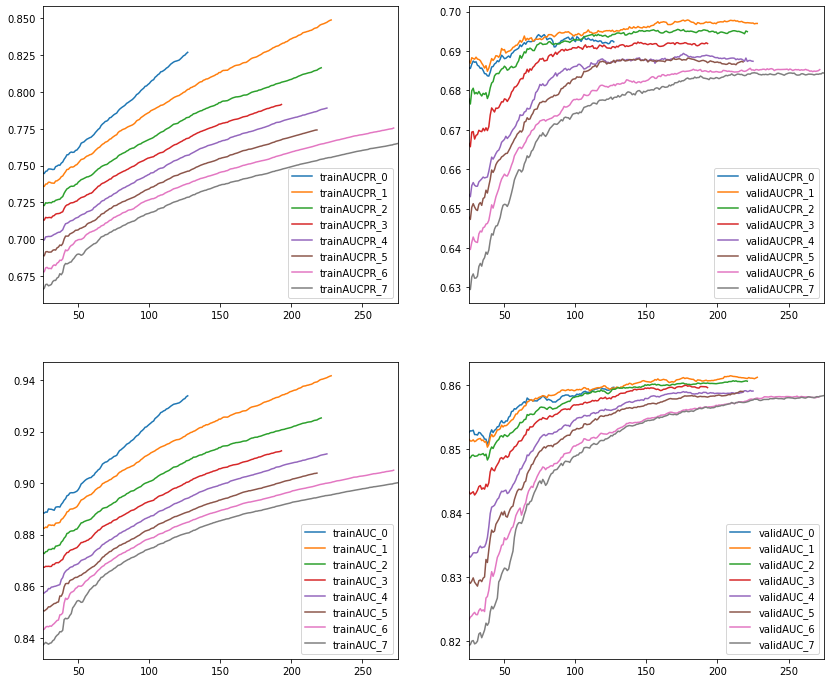

In [52]:
# Przygotowanie obiektu dla wyników
resHists = dict()
rang = range(0,8)
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features_standard, "Exited",
                                                                     lambdaX=x**2, max_depth=6, subsample=0.8,
                                                                     colsample_bytree=0.9, early_stopping_rounds=50,
                                                                     debug=False)
    # zapisanie historii
    resHists[x]=train_history
    print(x**2, score)
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
# wykresy historii po 25 obserwacji
for x in rang:
    resHists[x][['trainAUCPR']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[0, 0])
    resHists[x][['validAUCPR']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[0, 1])
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[1, 0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[1, 1])
plt.show()

Najlepsze wyniki najprawdopodobieniej znajdą się w przedziale 0-1.

1.0 0.697897
0.5 0.69694
0.3333333333333333 0.694406
0.25 0.698236
0.2 0.696418
0.16666666666666666 0.694402
0.14285714285714285 0.696247
0.125 0.696965
0.1111111111111111 0.697717
0.1 0.693079


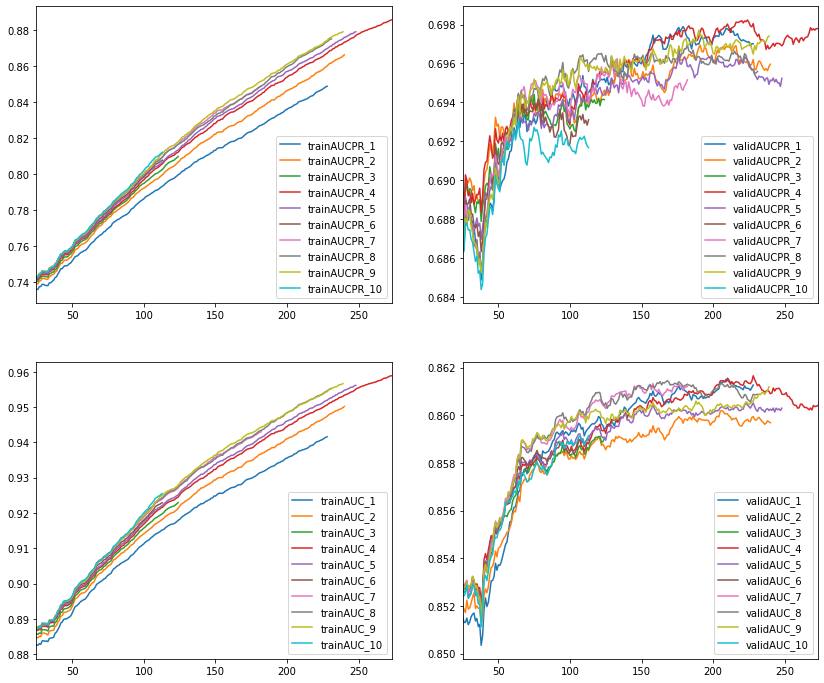

In [53]:
# Przygotowanie obiektu dla wyników
resHists = dict()
rang = range(1,11)
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features_standard, "Exited",
                                                                     lambdaX=1/x, max_depth=6, subsample=0.8,
                                                                     colsample_bytree=0.9, early_stopping_rounds=50,
                                                                     debug=False)
    # zapisanie historii
    resHists[x]=train_history
    print(1/x, score)
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
# wykresy historii po 25 obserwacji
for x in rang:
    resHists[x][['trainAUCPR']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[0, 0])
    resHists[x][['validAUCPR']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[0, 1])
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[1, 0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[1, 1])
plt.show()

Najlepszy wynik z regularyzacją 0.1-1, dokładnie najlepszy w tym przypadku okazał się 0.25.
 - gamma,

0 0.698236
0.01 0.697295
0.1 0.695891
0.5 0.696964
1 0.694746
2 0.698487
5 0.700277


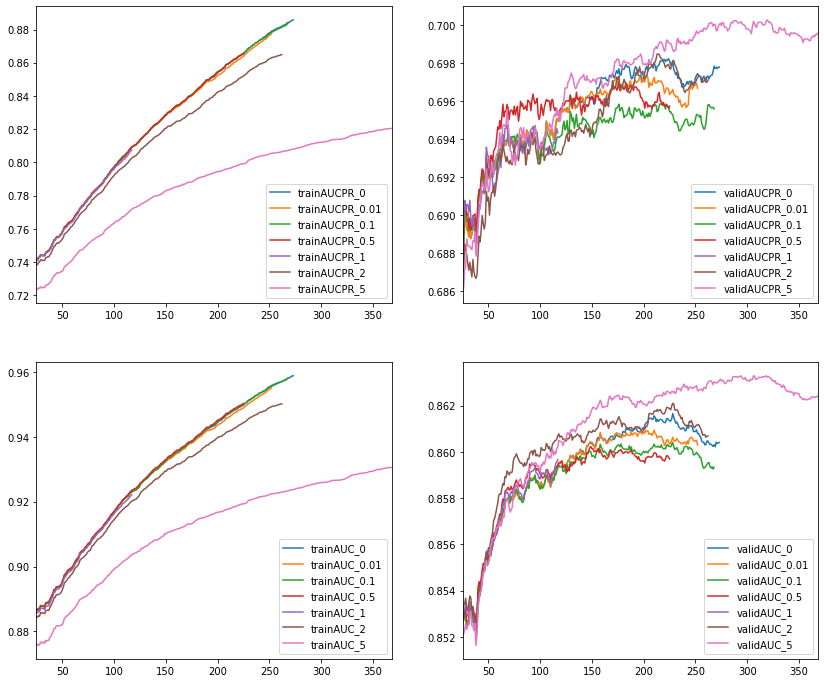

In [54]:
# Przygotowanie obiektu dla wyników
resHists = dict()
rang = [0, 0.01, 0.1, 0.5, 1, 2, 5]
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features_standard, "Exited",
                                                                     lambdaX=1/4, max_depth=6, subsample=0.8,
                                                                     colsample_bytree=0.9, gamma=x,
                                                                     early_stopping_rounds=50, debug=False)
    # zapisanie historii
    resHists[x]=train_history
    print(x, score)
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
# wykresy historii po 25 obserwacji
for x in rang:
    resHists[x][['trainAUCPR']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[0, 0])
    resHists[x][['validAUCPR']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[0, 1])
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[1, 0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[1, 1])
plt.show()

Zaskakujące, wysoka gamma, 5 dała zdecydowanie najlepsze rezultaty przy najniższych wynikach na zbiorze treningowym, czyli z najmniejszym przetrenowaniem! Może warto sprawdzić gammę w okolicy 5.

2 0.698487
3 0.700871
4 0.700136
5 0.700277
6 0.701964
7 0.701369
8 0.700486


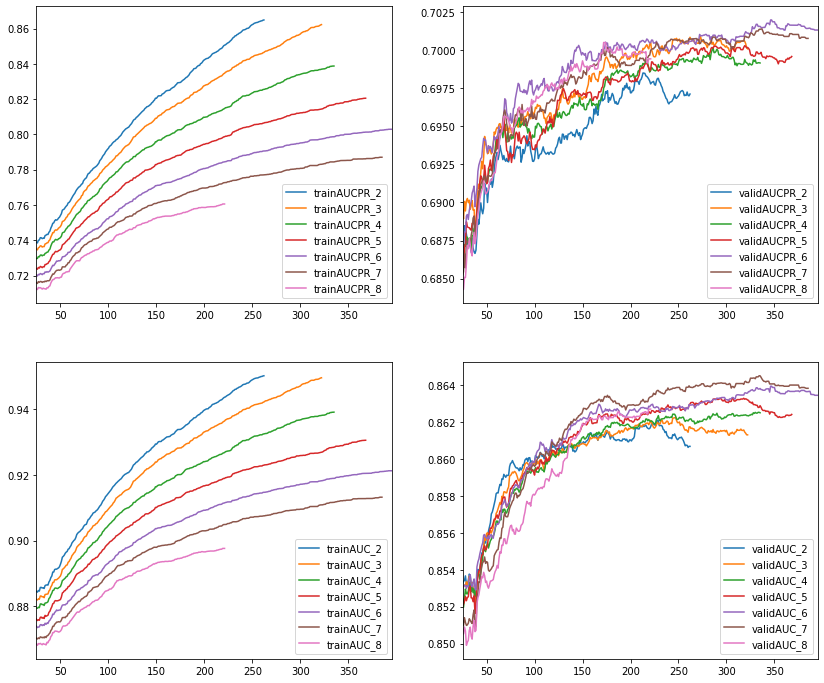

In [55]:
# Przygotowanie obiektu dla wyników
resHists = dict()
rang = [2, 3, 4, 5, 6, 7 ,8]
for x in rang:
    score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features_standard, "Exited",
                                                                     lambdaX=1/4, max_depth=6, subsample=0.8,
                                                                     colsample_bytree=0.9, gamma=x, 
                                                                     early_stopping_rounds=50, debug=False)
    # zapisanie historii
    resHists[x]=train_history
    print(x, score)
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
# wykresy historii po 25 obserwacji
for x in rang:
    resHists[x][['trainAUCPR']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[0, 0])
    resHists[x][['validAUCPR']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[0, 1])
    resHists[x][['trainAUC']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[1, 0])
    resHists[x][['validAUC']].add_suffix('_'+str(x)).iloc[25:].plot(ax=ax[1, 1])
plt.show()

Zakres można zawęzic na 3-8, z czego najlepszy wynik w tym przypadku to 6.<br/>
Mając określone zakresy hiperparametrów można przejśc do walidacji krzyżowej oraz random serarch

##### Walidacja krzyżowa XGB

In [56]:
def CVTestXGB(df = dfl, nFolds = 5, randomState=2020, features=features_standard, debug=False, *args, **kwargs):
    
    # warstwowa walidacja krzyżowa
    kf = StratifiedKFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # listy na wyniki
    ROCtestResults = []
    ROCtrainResults = []
    PRtestResults = []
    PRtrainResults = []
    predictions = []
    indices = []
    hists = []
    
    fold = 1
    for train, test in kf.split(df.index.values, df.Exited):
        # Przygotowanie estymatora
        score, trainPred, testPred, train_history, impFig, imp = run_xgb(df.iloc[train], df.iloc[test],
                                                                         features, 'Exited', debug=debug, *args, **kwargs)

        # zapisanie predykcji i indeksów dla pojedynczych foldów
        predictions.append(testPred.tolist().copy())
        indices.append(df.iloc[test].index.tolist().copy())
        
        # obliczenie metryk dla foldu
        ROCtrainScore = roc_auc_score(df['Exited'].iloc[train], trainPred)
        ROCtestScore = roc_auc_score(df['Exited'].iloc[test], testPred)
        PRtrainScore = average_precision_score(df['Exited'].iloc[train], trainPred)
        PRtestScore = average_precision_score(df['Exited'].iloc[test], testPred)
        
        # dodanie metryk do list
        ROCtrainResults.append(ROCtrainScore)
        ROCtestResults.append(ROCtestScore)
        PRtrainResults.append(PRtrainScore)
        PRtestResults.append(PRtestScore)
        
        # uzupełnienie historii
        hists.append(train_history.add_suffix('_'+str(fold)))
        fold+=1
        
        # tryb debuggowy
        if debug:
            print("Train AUC:", ROCtrainScore,
                  "Valid AUC:", ROCtestScore, 
                  "Train PR:", PRtrainScore,
                  "Valid PR:", PRtestScore)
        
    return ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, pd.concat(hists, axis=1)

Walidacja krzyżowa modelu z parametrami dobranymi sekwencyjnie.

In [57]:
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestXGB(dfl,
    features = features, max_depth=6, lambdaX=1/4, subsample=0.8, colsample_bytree=0.9, gamma=6, debug=False)

print('ROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}b'.format(
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

model_XGB_00 = {
    "name":"model_XGB_00",
    "description":"Model XGBoost z iteracyjnie dobranymi hiperparametrami z surowymi danymi",
    "specification":'max_depth=6, lambdaX=0.25, subsample=0.8, colsample_bytree=0.9, gamma = 6',
    "ROCtrainResults":ROCtrainResults.copy(),
    "ROCtestResults":ROCtestResults.copy(),
    "PRtrainResults":PRtrainResults.copy(),
    "PRtestResults":PRtestResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
    "variables":features_standard.copy()
}

zapis_model_XGB_00 = False
if zapis_model_XGB_00:
    with open("model_XGB_00.p", "wb") as fp:
        pickle.dump(model_XGB_00, fp)

ROC: 0.8687528741697736
PR: 0.7130273417724737
ROCtrain-test: 0.04508292592149599
PRtrain-test: 0.07456402305993515b


Jest to zdecydowanie lepszy wynik niż Random Forest, w szczególności w metryce PR, dodatkowo przetrenowanie jest znacznie mniejsze!
##### Random Search dla XGB
Poniżej znajduje się kod, przy pomocy którego znalezione zostały najlepsze parametry, z uwagi na czas wykonania nie jest on uruchomiony w niniejszym notatniku. Ten notatnik jest notatnikiem szykowanym dla czytelnika i zawiera uporządkowane informacje i kody z notatników roboczych.

In [58]:
'''
import random

# df z wynikami
rstls = pd.DataFrame(columns = ["max_depth", "lambdaX", "subsample", "colsample_bytree", "gamma", 
                               "ROCtest", "ROCtrain-test", "PRtest", "PRtrain-PRtest"])

# pętla iterująca
for k in range(50):
    # Przygotujmy słownik parametrów
    # Jako punkt odniesienia do wybranych przedziałów posłużą nam wcześniejsze wyniki
    params = {
        "max_depth" : random.randint(6, 8),
        "lambdaX" : random.randint(1, 10),
        "subsample" : random.randint(6, 9),
        "colsample_bytree" : random.randint(5, 9),
        "gamma" : random.randint(3, 8)
    }

    
    # Estymacja modelu dla wylosowanych hiperparametrów
    ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestXGB(
        max_depth = params["max_depth"],
        lambdaX = params["lambdaX"]/10, 
        subsample = params["subsample"]/10,
        colsample_bytree = params["colsample_bytree"]/10,
        gamma = params["gamma"], debug=False)
    
    # Zapis wyniku
    rstls = rstls.append(other = pd.DataFrame(data = np.array([params["max_depth"], params["lambdaX"]/10, params["subsample"]/10,
                        params["colsample_bytree"]/10, params["gamma"], np.mean(ROCtestResults),
                           np.mean(ROCtrainResults)-np.mean(ROCtestResults), np.mean(PRtestResults),
                           np.mean(PRtrainResults)-np.mean(PRtestResults)]).reshape(1, -1), columns = rstls.columns.tolist()), ignore_index=True)
    
    # wyświetlenie wyniku bieżącej iteracji
    print(np.round(rstls.iloc[k-1, :], 5).to_dict())
    print('-'*30)
    
    # wyświetlenie dotychczasowe top 5 co 10 iteracji
    if k > 1 and (k+1) % 10 == 0:    
        print("\n Top 5:")
        
        display(rstls.sort_values(by = "PRtest", ascending = False).head(5))'''

'\nimport random\n\n# df z wynikami\nrstls = pd.DataFrame(columns = ["max_depth", "lambdaX", "subsample", "colsample_bytree", "gamma", \n                               "ROCtest", "ROCtrain-test", "PRtest", "PRtrain-PRtest"])\n\n# pętla iterująca\nfor k in range(50):\n    # Przygotujmy słownik parametrów\n    # Jako punkt odniesienia do wybranych przedziałów posłużą nam wcześniejsze wyniki\n    params = {\n        "max_depth" : random.randint(6, 8),\n        "lambdaX" : random.randint(1, 10),\n        "subsample" : random.randint(6, 9),\n        "colsample_bytree" : random.randint(5, 9),\n        "gamma" : random.randint(3, 8)\n    }\n\n    \n    # Estymacja modelu dla wylosowanych hiperparametrów\n    ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestXGB(\n        max_depth = params["max_depth"],\n        lambdaX = params["lambdaX"]/10, \n        subsample = params["subsample"]/10,\n        colsample_bytree = params["colsample_bytree"]/

Poniższy kod również nie zostanie uruchomiony w tym notatniku, zamieszczony jednak został archiwalny screen. Niestety z nie najlepszego przebiegu, wcześniej znalezione zostały odrobinę lepsze parametry.

In [59]:
'''# max kryterium PR
display(rstls.where(rstls.PRtest == rstls.PRtest.max()).dropna())
# max kryterium ROC
display(rstls.where(rstls.ROCtest == rstls.ROCtest.max()).dropna())

# min kryterium PR
display(rstls.where(rstls.PRtest == rstls.PRtest.min()).dropna())
# min kryterium ROC
display(rstls.where(rstls.ROCtest == rstls.ROCtest.min()).dropna())'''

'# max kryterium PR\ndisplay(rstls.where(rstls.PRtest == rstls.PRtest.max()).dropna())\n# max kryterium ROC\ndisplay(rstls.where(rstls.ROCtest == rstls.ROCtest.max()).dropna())\n\n# min kryterium PR\ndisplay(rstls.where(rstls.PRtest == rstls.PRtest.min()).dropna())\n# min kryterium ROC\ndisplay(rstls.where(rstls.ROCtest == rstls.ROCtest.min()).dropna())'

![alt text](img\RSXGB.PNG)

#### Feature importance

Multiple eval metrics have been passed: 'valid-aucpr' will be used for early stopping.

Will train until valid-aucpr hasn't improved in 50 rounds.
Stopping. Best iteration:
[263]	train-auc:0.903731	train-aucpr:0.774391	valid-auc:0.866428	valid-aucpr:0.711325

Czas trenowania: 0.06 minut
Train AUC: 0.9037356483814059 Valid AUC: 0.8663861587348508 Train PR: 0.7744907078317809 Valid PR: 0.7115775861274306
Multiple eval metrics have been passed: 'valid-aucpr' will be used for early stopping.

Will train until valid-aucpr hasn't improved in 50 rounds.
Stopping. Best iteration:
[344]	train-auc:0.906718	train-aucpr:0.778267	valid-auc:0.872532	valid-aucpr:0.721893

Czas trenowania: 0.08 minut
Train AUC: 0.9066802853900122 Valid AUC: 0.8725490196078431 Train PR: 0.7781714651871815 Valid PR: 0.7220720495649223
Multiple eval metrics have been passed: 'valid-aucpr' will be used for early stopping.

Will train until valid-aucpr hasn't improved in 50 rounds.
Stopping. Best iteration:
[557]	train-auc

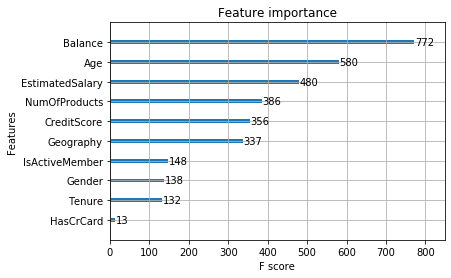

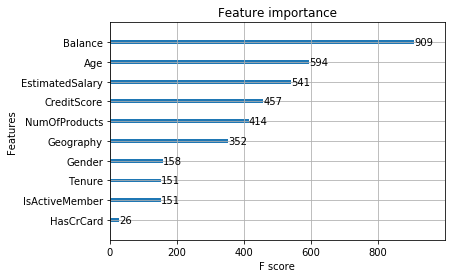

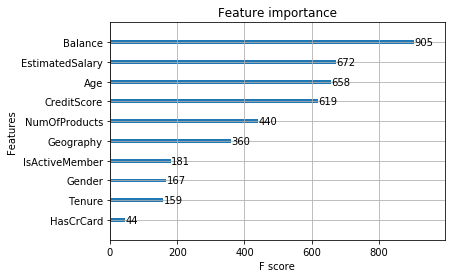

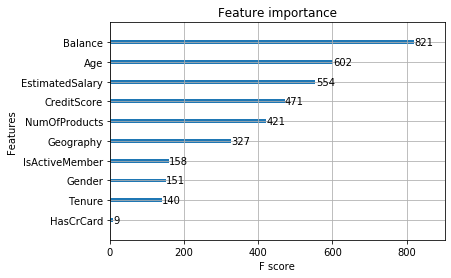

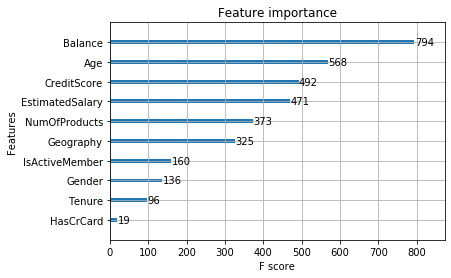

In [60]:
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestXGB(
        df = dfl,
        features = features_standard,
        max_depth = 8,
        lambdaX = 2, 
        subsample = 0.9,
        colsample_bytree = 0.6,
        gamma = 6, debug = 'half')

print('{}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format('-'*30,
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

model_XGB_01 = {
    "name":"model_XGB_01",
    "description":"Model XGBoost z losowanymi hiperparametrami z surowymi danymi",
    "specification":'max_depth=8, lambdaX=2, subsample=0.9, colsample_bytree=0.6, gamma = 6',
    "ROCtrainResults":ROCtrainResults.copy(),
    "ROCtestResults":ROCtestResults.copy(),
    "PRtrainResults":PRtrainResults.copy(),
    "PRtestResults":PRtestResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
    "variables":features.copy()
}

zapis_model_XGB_01 = False
if zapis_model_XGB_01:
    with open("model_XGB_01.p", "wb") as fp:
        pickle.dump(model_XGB_01, fp)

Udało się poprawić PR o 0.02, ROC kosmetyczna poprawa.
##### Feature engineering (zmienne ciągłe najwyżej punktowane)
- logarytm EstimatedSalary,

In [61]:
from hpl import smart_log_var
# dodanie logarytmu EstimatedSalary do dfl
smart_log_var(dfl, 'EstimatedSalary')

# nowe zmienne objaśniające
featureslogSal = dfl.columns.tolist()
featureslogSal.remove('Exited')
featureslogSal.remove('EstimatedSalary')
featureslogSal

['CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary_log']

In [62]:
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestXGB(
        df = dfl,
        features = featureslogSal,
        max_depth = 8,
        lambdaX = 2, 
        subsample = 0.9,
        colsample_bytree = 0.6,
        gamma = 6, debug = False)

print('{}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format('-'*30,
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

------------------------------
ROC: 0.8704668798195065
PR: 0.7157624293852868
ROCtrain-test: 0.035816266484429926
PRtrain-test: 0.06269002969389792


Brak rezultatów.

 - kategoryzacja zmiennej Balance (decyle)

In [63]:
dfl["BalanceCut"] = pd.cut(dfl["Balance"], 
       [-0.1, 0.0, 73081.0, 97199.0, 110139.0, 122030.0, 133710.0, 149245.0, 250899], 
       labels = ['zero', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10'])

df["BalanceCut"] = pd.cut(df["Balance"], 
       [-0.1, 0.0, 73081.0, 97199.0, 110139.0, 122030.0, 133710.0, 149245.0, 250899], 
       labels = ['zero', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10'])

# zmienne kategoryzujące
catBalCut = cat.copy()
catBalCut.append("BalanceCut")

df['BalanceCut'] = df['BalanceCut'].astype(str)
dfl['BalanceCut'] = dfl['BalanceCut'].astype(str)

# Kopiowanie obiektu
dfc = dfl.copy()
# Słownik zawierachąch mapy
mapy = {}
for feature in catBalCut:
    le = preprocessing.LabelEncoder()
    dfc[feature] = le.fit_transform(df[feature])
    mapy[feature] = le
    
# Sprawdzenie klas dla BalanceCut
print(mapy['BalanceCut'].classes_)

print('Wszystko ok:', 
pd.Series(df["BalanceCut"].values).equals( # seria z oryginalnego df
    pd.Series(mapy['BalanceCut'].inverse_transform(dfc["BalanceCut"])))) # seria z kopii po odzyskaniu labeli

['D10' 'D4' 'D5' 'D6' 'D7' 'D8' 'D9' 'zero']
Wszystko ok: True


In [64]:
featuresBalCut = dfl.columns.tolist()
featuresBalCut.remove('Balance')
featuresBalCut.remove('Exited')
featuresBalCut.remove('EstimatedSalary_log')
featuresBalCut

['CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'BalanceCut']

In [65]:
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestXGB(
        df = dfc,
        features = featuresBalCut,
        max_depth = 8,
        lambdaX = 2, 
        subsample = 0.9,
        colsample_bytree = 0.6,
        gamma = 6, debug = False)

print('{}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format('-'*30,
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

------------------------------
ROC: 0.8681329363746778
PR: 0.7109631961120775
ROCtrain-test: 0.029840885588946264
PRtrain-test: 0.051474249030413644


Powyższy eksperyment pokazuje, że kategoryzacja zmiennej ciągłej w algorytmie opartym o drzewa decyzyjne nie przynosi dobrych rezultatów (co nie wyklucza przydatności takiej transformacji w przypadku korzystania z innych algorytmów)

In [66]:
# logarytmowanie
smart_log_var(dfl, 'Balance')

# lista zmiennych objaśniających
featureslogBal = dfl.columns.tolist()
featureslogBal.remove('Exited')
featureslogBal.remove('EstimatedSalary')
featureslogBal.remove('BalanceCut')
featureslogBal.remove('Balance')
featureslogBal

['CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary_log',
 'Balance_log']

In [67]:
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestXGB(
        df = dfl,
        features = featureslogBal,
        max_depth = 8,
        lambdaX = 2, 
        subsample = 0.9,
        colsample_bytree = 0.6,
        gamma = 6, debug = False)

print('{}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format('-'*30,
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

------------------------------
ROC: 0.8695312077387898
PR: 0.7137055554632885
ROCtrain-test: 0.03176371457314786
PRtrain-test: 0.0558910191973816


logarytmowanie Balance to również nie najlepszy pomysł.

 - Logarytmowanie wieku

In [68]:
# logarytmowanie Age
smart_log_var(dfl, 'Age')

featureslogAge = dfl.columns.tolist()
featureslogAge.remove('Exited')
featureslogAge.remove('EstimatedSalary_log')
featureslogAge.remove('BalanceCut')
featureslogAge.remove('Balance_log')
featureslogAge.remove('Age')
featureslogAge

['CreditScore',
 'Geography',
 'Gender',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Age_log']

In [69]:
ROCtrainResults, ROCtestResults, PRtrainResults, PRtestResults, predictions, indices, hists = CVTestXGB(
        df = dfl,
        features = featureslogAge,
        max_depth = 8,
        lambdaX = 2, 
        subsample = 0.9,
        colsample_bytree = 0.6,
        gamma = 6, debug = False)

print('{}\nROC: {}\nPR: {}\nROCtrain-test: {}\nPRtrain-test: {}'.format('-'*30,
    np.mean(ROCtestResults),
    np.mean(PRtestResults), 
    np.mean(ROCtrainResults)-np.mean(ROCtestResults),
    np.mean(PRtrainResults)-np.mean(PRtestResults)))

------------------------------
ROC: 0.8673042989625278
PR: 0.7091003851338948
ROCtrain-test: 0.029597577612390125
PRtrain-test: 0.052607214121382806


Brak korzyści z powyższych prób.

In [70]:
# usunięcie pozostałości
df.drop('BalanceCut', axis = 1, inplace = True)

##### Porównanie najlepszych modeli na zmiennych standardowych z logitem

In [71]:
print('---Logit---\nROC: {}\nPR: {}'.format(np.mean(model_logit_00['ROCtestResults']), np.mean(model_logit_00['PRtestResults'])))
print('\n---Random Forest---\nROC: {}\nPR: {}'.format(np.mean(model_RF_02['ROCtestResults']), np.mean(model_RF_02['PRtestResults'])))
print('\n---XGB---\nROC: {}\nPR: {}'.format(np.mean(model_XGB_01['ROCtestResults']), np.mean(model_XGB_01['PRtestResults'])))

---Logit---
ROC: 0.7648486062899543
PR: 0.4695414516144849

---Random Forest---
ROC: 0.8617968197816749
PR: 0.6954932334652437

---XGB---
ROC: 0.8704668803822816
PR: 0.715762887197929


Wyniki Random Forest pokazują, że warto poświęcić więcej czasu na EDA, być może uda się uzyskać lepsze wyniki w logicie, co przełoży się na możliwość stworzenia lepszego modelu głównego (ensembling).

In [72]:
kernelstop = time.time()
print('Uruchomienie całego kernela trwało: {}'.format(round(kernelstop-kernelstart), 2))

Uruchomienie całego kernela trwało: 756
